In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
import re

In [18]:
# Read CSV Files
puppy_info = pd.read_excel('PuppyInfo.xls')
puppy_trainer_outcome = pd.read_excel('PuppyTrainerOutcome.xlsx')
trainer_info = pd.read_excel('TrainerInfo.xlsx')

In [19]:
print(len(puppy_info), len(puppy_trainer_outcome), len(trainer_info))

4782 28063 1688


# Processing Data

The first step in preparing our data for our machine learning algorithm is processing. We will start by cleaning up the data for a few of the important columns.

## Sex

In [20]:
def process_sex(df):
    target_for_values = {
    'F': ['bitch','remale','f','Female','fem','fema;e','F','    F','Femae','Femail','Femaile','Femal','Femal3','Female','Femalw','femle','FEMALE','female','Girl','ID#2099','girl','n/a','None','own','Unknown','1364 & 655','1112/1329','065 102 601','2052','2235','11796','1972','1677','1649','1590','1395','1070','219','0','696','1018','ID# 2099','femal','femalw','Famale','femaile','femail']}

    for k, v in target_for_values.items():
        df.loc[df.Sex.isin(v), 'Sex'] = k

    target_for_values = {
    'M': ['Male','1110','1231','1627','1644','1766','1870','2019','??','1JJ11','boy','Crate from Val and Jim Hazlin','don\'t have one.','M - neutered','maie','Mail','Maile','Make','make','Male - neutered','male (neutered)','"Male, neutered"','Male1832','mine doesn\'t have a number?','N/A','NA','Neutered Male','new crate','none','own crate','Weren\'t given a crate','m','male','MALE','Male', 'Male','neutered mail','mail','Male, neutered',' Neutered Male']}

    for k, v in target_for_values.items():
        df.loc[df.Sex.isin(v), 'Sex'] = k

process_sex(puppy_info)
print(puppy_info['Sex'].fillna('M', inplace = True))
        
print(puppy_info['Sex'].value_counts())
print(puppy_info['Sex'].unique())

puppy_info['Sex']=puppy_info['Sex'].map({'F':0, 'M':1, 0:0, 1:1}).astype(int)

None
M    2400
F    2382
Name: Sex, dtype: int64
['F' 'M']


## Attends Classes


In [21]:
print(puppy_info['AttendsClasses'].value_counts())

# Replace missing values with 4.0 (mean is 796 which is close to 4.0
# category)
puppy_info['AttendsClasses'].fillna(4.0,inplace = True)

5.0    3393
4.0     771
0.0     417
3.0     135
1.0      41
2.0      23
Name: AttendsClasses, dtype: int64


## Exercise Amount

In [22]:
# Extract the first number and process it into minute values
def getFirstNumber(string):
    find_num = re.search(r'\d+', string)
    if(find_num == None):
        # Process words into numbers
        if "one" in string or "an hour" in string:
            return 60
        elif "two" in string:
            return 120
        elif "three" in string:
            return 180
        elif "hour and half" in string:
            return 90
        elif "twenty" in string:
            return 20
        elif "forty" in string:
            return 45
        elif "hour" in string and not "hours" in string:
            return 60
        return 0
    
    # Process numbers into minute values
    num = int(find_num.group())
    if int(num < 10):
        return num*60
    return num

# Process minute values to most important/common times
def averageTime(num, replaceZeroValue = 60):
    if num == 0:
        return replaceZeroValue
    
    time_classes = [0, 20, 40, 60, 90, 120, 180, 440]
    for time_val in time_classes:
        if time_val >= num:
            return time_val
    
    return 440

def process_exercise_amt(puppy_info):
    puppy_exercise_amt = puppy_info["ExericeAmount"].map(lambda x: str(x).lower())
    puppy_exercise_processed = list(map(lambda x: averageTime(int(getFirstNumber(str(x)))), puppy_exercise_amt))

    puppy_info["ExericeAmount"] = puppy_exercise_processed

process_exercise_amt(puppy_info)
print("Distinct time values:", puppy_info["ExericeAmount"].unique())

exercise_amt_counts = Counter(puppy_info["ExericeAmount"])
exercise_amt_counts = list(map(lambda x: (x, exercise_amt_counts[x]), exercise_amt_counts))
exercise_amt_counts.sort()
print("Counts:", exercise_amt_counts)

Distinct time values: [ 90 120  60 440 180  40  20]
Counts: [(20, 147), (40, 604), (60, 2137), (90, 608), (120, 924), (180, 263), (440, 99)]


## Breed

In [23]:
def breed_mappings(breed):
    if breed == "golden labrador" or breed == "golden lab":
        return "golden labrador"
    elif breed in ["belgian shepherd", "belgen sharpart"]:
        return "belgian shepherd"
    elif "rador" in breed or "lab" in breed or breed[0:2] == "la" or breed in ["lr", "l", "bl", "labrador retriever"]:
        return "labrador retriever"
    elif "german shep" in breed or breed in ["gs", "gds", "greman shepherd", "geman shepherd", "gsd", "gsp", "g.s.", "german shepherd"] or "german sh" in breed or "shep" in breed:
        return "german shepherd"
    elif breed in ["gr", "golden retriever"] or "golden retr" in breed:
        return "golden retriever"
    elif breed in ["unknown", "black", "golden", "lym", "lbm", "ly m", "ged", "gdd", "noble", "nan"]:
        # Replace with the most common dog breed: Labrador retriever
        return "labrador retriever"
        # return "unknown"
    else:
        return breed

def process_breed(puppy_info):
    puppy_info["Breed"] = puppy_info["Breed"].map(lambda x: breed_mappings(str(x).lower()))
    
process_breed(puppy_info)
print(puppy_info["Breed"].unique())

['labrador retriever' 'german shepherd' 'golden labrador'
 'golden retriever' 'belgian shepherd']


In [24]:
breed_counts = Counter(puppy_info["Breed"])
print(breed_counts)

puppy_info['Breed']=puppy_info['Breed'].map({
    'labrador retriever': 1,
    'german shepherd': 2,
    'golden labrador': 3,
    'golden retriever': 4,
    'belgian shepherd': 5,
    '1':1,
    '2':2,
    '3':3,
    '4':4,
    '5':5}).astype(int)

print(puppy_info["Breed"].unique())

Counter({'labrador retriever': 4397, 'german shepherd': 347, 'golden retriever': 33, 'golden labrador': 4, 'belgian shepherd': 1})
[1 2 3 4 5]


## Color

In [25]:
target_for_color = {
    'Sable': ['Coated Sable','Sable','sable'],
    'Yellow': ['blond','Blond/Yellow','Blonde','blondelab lode','Butterscotch','Carmel Yellow','cream','Cream','darkish brown','fox red','Gold','gold','golden','GOLDEN','Golden Yellow','Lab','light tan','light yellow','Light Yellow','red','Red','Red Fox','Rust','Tan','tan','WELLOW','Wheat','white','White','White and yellow','White/Yellow','Y','y','yel','Yel','Yellllow','Yello','YELLO','yello','yelloiw','Yellow','yellow','YELLOW','Yellow - Dark','Yellow (red)','Yellow & White','yellow lab','Yellow with black trim','Yellow/Butterscotch','yellow/cream','Yellow/White','yellow1','yellowf','Light yellow','Yellowf'],
    'Golden': ['camel','golden/red','goldish','honey','Light Golden','Medium Gold','red/gold','reddish gold','warm gold','warm honey','Tan/Gold'],
    'Black/tan': ['B & T','b/t','B&T','B+T','bl and tan','Black & Tan','Black &tan','Black + Tan','Black and ran','Black and tan','Black and tan (?)','Black Brown','black tan','black w/ tan','Black, tan','Black, tan, silver','Black,tan','Black/ Tan','black/brown','Black/Tan','black+ tan','Blk & Tan','Blk and Tan','Blk/Tan','Brown & Black','brown black','Brown-Black','Brown, black','Brown/Black','Brown/Black/Tan','Coated Black','tan and black','Tan/Black','black and tan','Black and Tan','Bicolor (Black & red)','Bicolor (black w/ brown legs)','Black & red','Black and ran','Black and Red','black and white','Tri','Tri color','Brindle','GSD','B/T','b&t','Black / Tan','black & tan','black, tan','Black/tan','blk and tan','Blk/TAn','tan/black','Blk and tan','Black & tan','black/tan',],
    'Black': ['Color', 'B','Bl','Bl','blac','black (and beautiful)','blck,','Blk','Blk.','blsck','back','black','BLACK','blk','BLK','color','lab',' Black','blck','Back','BLK.','BLack','nan']
}

def process_color(puppyinfo):
    # Replace messy color values
    for k, v in target_for_color.items():
        puppyinfo.loc[puppyinfo.Color.isin(v), 'Color'] = k
    
    # Replaced missing values with Black
    puppyinfo['Color'].fillna('Black',inplace = True)

process_color(puppy_info)
print(puppy_info.Color.unique())

puppy_info['Color']=puppy_info['Color'].map({'Black': 1, 'Yellow': 2, 'Black/tan': 3, 'Sable': 4, 'Golden': 5, 1:1, 2:2, 3:3, 4:4, 5:5}).astype(int)


['Black' 'Yellow' 'Black/tan' 'Sable' 'Golden']


# Status Code

In [9]:
def process_status_code(df):
    df.dog_SubStatusCode.replace([23,25,26,27,55,98,121,169],[1,1,1,1,1,1,1,1], inplace=True)
    df.dog_SubStatusCode[df.dog_SubStatusCode != 1] = 0

process_status_code(puppy_trainer_outcome)
puppy_trainer_outcome['dog_SubStatusCode'].unique()

/Users/williamnguyen/anaconda3/envs/cs274/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([1, 0])

# Merge Data

In [26]:
puppy_info.rename(columns={'ogr_DogID': 'DogID', 'Raiser_psn_PersonID': 'PersonID', 'ExericeAmount': 'ExerciseAmount'}, inplace=True)
puppy_trainer_outcome.rename(columns={'dog_DogID': 'DogID', 'ogr_PersonID': 'PersonID'}, inplace=True)

In [29]:
puppy_info = puppy_info.drop_duplicates(['DogID'], keep='first')
puppy_trainer_outcome = puppy_trainer_outcome.drop_duplicates(['DogID'], keep='first')

print(len(puppy_info), len(puppy_trainer_outcome))

2138 12677


In [30]:
puppy_trainer_outcome

,DogID,dog_Tattoo,dog_CallName,dog_LitterID,dog_BreederID,dog_DOB,dog_Sex,dog_StatusChangeDate,dog_SubStatusCode,dbc_DogBreedDescription,Dog_EndReasonText,dbcc_ColorDescription,ogr_RelationID,PersonID,ogr_DateStart,ogr_DateEnd,ogr_DateRefused,Relationship_Description
0,20500,5S315,Sparky,S315,7105.0,2015-10-29,M,2015-10-29,1,Labrador Retriever,No_END,Black,52210,22749,2015-12-30,NaN,NaN,Puppy Raiser/primary
1,20496,1S315,Spirit,S315,7105.0,2015-10-29,F,2015-10-29,1,Labrador Retriever,No_END,Yellow,52212,4909,2015-12-30,NaN,NaN,Adopter of dog
2,20506,6T315,Topher,T315,7105.0,2015-11-06,M,2015-11-06,1,German Shepherd,No_END,Black/tan,52223,14273,2015-12-31,NaN,NaN,Adopter of dog
3,20494,9R315,Raj,R315,7105.0,2015-10-22,M,2015-12-17,2,Labrador Retriever,No_END,Yellow,52203,20181,2015-12-27,NaN,NaN,Puppy Raiser/primary
4,20490,5R315,Rhyme,R315,7105.0,2015-10-22,F,2015-12-18,2,Labrador Retriever,No_END,Yellow,52213,4909,2015-12-30,NaN,NaN,Adopter of dog
5,20491,6R315,Regal,R315,7105.0,2015-10-22,F,2015-12-18,3,Labrador Retriever,No_END,Black,52192,18842,2015-12-20,NaN,NaN,Puppy Raiser/primary
6,20455,2M315,Maggie,M315,7105.0,2015-10-07,F,2015-11-30,3,Labrador Retriever,No_END,Black,52193,20106,2015-12-19,NaN,NaN,Puppy Raiser/primary
7,20480,4P315,Peace,P315,7105.0,2015-10-21,F,2015-12-17,3,Labrador Retriever,No_END,Yellow,52179,26252,2015-12-19,NaN,NaN,Puppy Raiser/primary
8,20488,3R315,Riley,R315,7105.0,2015-10-22,F,2015-12-17,3,Labrador Retriever,No_END,Yellow,52191,21435,2015-12-20,NaN,NaN,Puppy Raiser/primary
9,18413,6K313,Kenner,K313,7105.0,2013-08-16,M,2014-12-16,17,Labrador Retriever,No_END,Black,47324,17477,2013-11-23,2014-07-18 00:00:00,NaN,Puppy Raiser/primary


In [31]:
dog_id_count = Counter(puppy_info['DogID'])
num_repeated_dog_ids = Counter( [dog_id_count[i] for i in dog_id_count] )
print(len(puppy_info), num_repeated_dog_ids)

2138 Counter({1: 2138})


In [32]:
puppy_merged = puppy_info.merge(puppy_trainer_outcome, on=['DogID'], how='outer')

print(len(puppy_info), len(puppy_trainer_outcome), len(puppy_merged))

2138 12677 12705


In [33]:
puppy_merged

,SurveyID,DogID,PersonID_x,ogr_DateStart_x,ogr_DateEnd_x,DOB,Dog,Tattoo,Age,Breed,...,dog_SubStatusCode,dbc_DogBreedDescription,Dog_EndReasonText,dbcc_ColorDescription,ogr_RelationID,PersonID_y,ogr_DateStart_y,ogr_DateEnd_y,ogr_DateRefused,Relationship_Description
0,2822.0,20446,28298.0,2015-12-14,NaN,2015-09-20 00:00:00,Lucille,13L315,4 months,1.0,...,111.0,Labrador Retriever,No_END,Black,52109.0,28298.0,2015-12-14,NaN,NaN,Puppy Raiser/primary
1,2096.0,20427,2481.0,2015-12-12,NaN,2015-09-19 00:00:00,Janelle,9J315,3.5 months,1.0,...,111.0,Labrador Retriever,No_END,Yellow,52105.0,2481.0,2015-12-12,NaN,NaN,Puppy Raiser/primary
2,2313.0,20423,28396.0,2015-12-05,NaN,2015-09-19 00:00:00,Junior,5J315,4 mos,1.0,...,111.0,Labrador Retriever,No_END,Yellow,52058.0,28396.0,2015-12-05,NaN,NaN,Puppy Raiser/primary
3,2172.0,20421,28143.0,2015-11-21,NaN,2015-09-19 00:00:00,Jess,3J315,4 months,1.0,...,111.0,Labrador Retriever,No_END,Yellow,51994.0,28143.0,2015-11-21,NaN,NaN,Puppy Raiser/primary
4,2154.0,20420,28326.0,2015-11-21,NaN,2015-09-19 00:00:00,Jenny,2J315,16 weeks,1.0,...,111.0,Labrador Retriever,No_END,Yellow,51993.0,28326.0,2015-11-21,NaN,NaN,Puppy Raiser/primary
5,1943.0,20414,21290.0,2015-12-05,NaN,2015-09-27 00:00:00,Iggie,2I315,14 weeks,1.0,...,111.0,Labrador Retriever,No_END,Black,52057.0,21290.0,2015-12-05,NaN,NaN,Puppy Raiser/primary
6,1830.0,20412,22827.0,2015-11-10,NaN,2015-09-12 00:00:00,Heart,8H315,16 weeks,1.0,...,111.0,Labrador Retriever,No_END,Yellow,51926.0,22827.0,2015-11-10,NaN,NaN,Puppy Raiser/primary
7,1896.0,20410,20468.0,2015-11-10,NaN,2015-09-12 00:00:00,Honey,6H315,3 months,1.0,...,111.0,Labrador Retriever,No_END,Yellow,51927.0,20468.0,2015-11-10,NaN,NaN,Puppy Raiser/primary
8,1471.0,20402,12865.0,2015-11-09,NaN,2015-09-09 00:00:00,Gala,8G315,16 weeks,1.0,...,111.0,Labrador Retriever,No_END,Yellow,51919.0,12865.0,2015-11-09,NaN,NaN,Puppy Raiser/primary
9,1483.0,20400,27227.0,2015-11-30,NaN,2015-09-09 00:00:00,Gammie,6G315,4mnths,1.0,...,111.0,Labrador Retriever,No_END,Yellow,52021.0,27227.0,2015-11-30,NaN,NaN,Puppy Raiser/primary


# Column Comparisons with Covariance Matrix

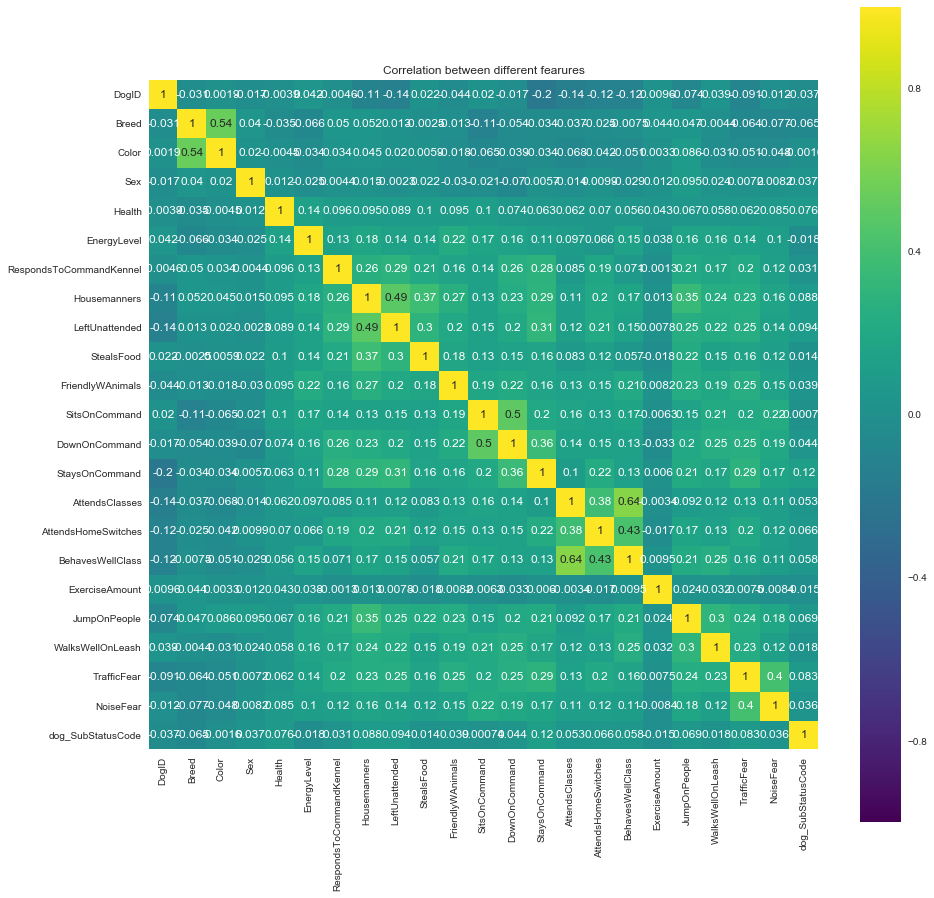

In [14]:
select = ['DogID',
          'Age',
          'Breed',
          'Color',
          'Sex',
          'Health',
          'EnergyLevel',
          'RespondsToCommandKennel', 
          'Housemanners',
          'LeftUnattended',
          'StealsFood',
          'FriendlyWAnimals',
          'SitsOnCommand', 
          'DownOnCommand',
          'StaysOnCommand',
          'AttendsClasses',
          'AttendsHomeSwitches',
          'BehavesWellClass', 
          'ExerciseType',
          'ExerciseAmount',
          'JumpOnPeople',
          'WalksWellOnLeash',
          'TrafficFear',
          'NoiseFear',
          'dog_SubStatusCode'
         ]

def view_correlation(select, df):
    data = df[select]
    correlation = data.corr()
    plt.figure(figsize=(15,15))
    sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

    plt.title('Correlation between different fearures')
    return plt

plt = view_correlation(select, puppy_merged)
plt.show()

# Select 10 Columns

In [15]:
desired_columns = [
    'AttendsClasses', # Or BehavesWellInClass
    'AttendsHomeSwitches',
    'ExerciseAmount',
    'Breed',
    'Sex',
    'Housemanners',
    'FriendlyWAnimals',
    'JumpOnPeople',
    'StaysOnCommand',
    'TrafficFear',
    'dog_SubStatusCode'
]

processed_data = puppy_merged[desired_columns]

# Write Out Data

In [16]:
processed_data.to_csv('ProcessedPuppyInfo.csv', index=False)